# Plot regret of NCC-UCRL2 (new name of Algorithm1) for different window sizes


In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pickle

import algorithms
from src import evaluation
from src import costs
from src.plotting.costs import plot_costs

In [3]:
np.random.seed(42)

# Load the evaluation data saved in experiment 20

In [4]:
with open('dataset/nursery/nursery_evaluation.pickle', 'rb') as f:
    data = pickle.load(f)
    
all_contexts, all_rewards = data

In [5]:
all_contexts

,form,children,housing,finance,health
2,1,1,1,1,1
4,1,1,1,1,3
6,1,1,1,1,2
7,1,1,1,1,3
8,1,1,1,1,1
...,...,...,...,...,...
12952,4,4,3,2,3
12953,4,4,3,2,1
12955,4,4,3,2,3
12956,4,4,3,2,1


In [6]:
all_rewards

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

## Set BETA parameter for the experiment

In [7]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [8]:
all_rewards.shape[0]

10000

In [9]:
stationarity_regions = [
    slice(0, 1000),
    slice(1000, 2000),
    slice(2000, 5000),
    slice(5000, 8000),
    slice(8000, all_contexts.shape[0]),
]

In [10]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [11]:
change_point_values

[1, 1000, 2000, 5000, 8000, 10000]

In [12]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.3396, 0.3366, 0.3238])

In [13]:
nonstationary_rewards = np.copy(all_rewards)
nonstationary_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(nonstationary_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        
        additional_shift = 0
        if i == 1 or i == 3:
            additional_shift = 1
        elif i == 2:
            additional_shift = 2
        
        # Cyclic shift of class labels
        arm_to = (arm_from + i + additional_shift) % n_arms
        if i > 0:
            nonstationary_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(nonstationary_rewards[region, arm_to].shape) * np.mean(nonstationary_rewards[region, arm_to])
        )

In [14]:
nonstationary_contexts.shape, nonstationary_rewards.shape

((10000, 5), (10000, 3))

## Plot expected reward

Min expected reward for arm 1: 0.24433333333333335
Min expected reward for arm 2: 0.022
Min expected reward for arm 3: 0.0


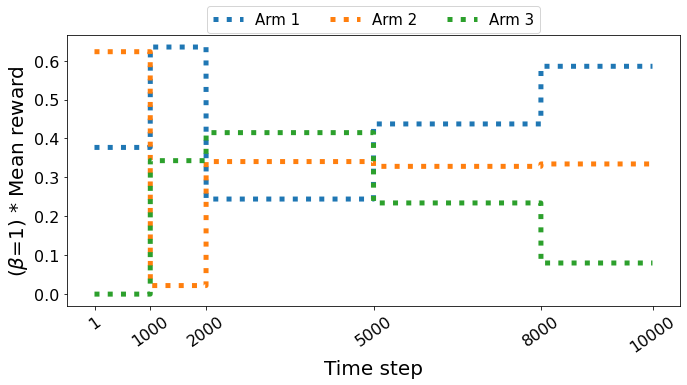

In [15]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


# Exchange rows
Here we exchange the rows between stationarity regions. We do this so that we can achieve the pattern of mean rewards as specified in the beginning of this document.

In [16]:
def exchange_rows(array, rows1:list, rows2: list):
    array = array.copy()
    assert len(rows1) == len(rows2)
    assert len(set(rows1)) == len(rows1)
    assert len(set(rows2)) == len(rows2)
    assert set(rows1).intersection(set(rows2)) == set()
    temp1 = array[rows1].copy()
    temp2 = array[rows2].copy()

    array[rows1] = temp2
    array[rows2] = temp1
    return array

In [17]:
def rebalance_arms_between_regions(
    contexts, rewards, arm_1, arm_2, region_1, region_2, percentage,
):
    assert arm_1 != arm_2
    assert region_1 != region_2
    """Exchange rows in both context and reward arrays in such a way that rows
    for arm_1 in region_1 are exchanged with arm_2 in region_2.
    
    """
    region_1_slice = stationarity_regions[region_1]
    reg_1_mask = np.zeros(contexts.shape[0], dtype=bool)
    reg_1_mask[region_1_slice] = True
    
    region_2_slice = stationarity_regions[region_2]
    reg_2_mask = np.zeros(contexts.shape[0], dtype=bool)
    reg_2_mask[region_2_slice] = True
    
    arm_1_mask = np.array(rewards[:, arm_1], dtype=bool)
    arm_2_mask = np.array(rewards[:, arm_2], dtype=bool)
    
    mask1 = arm_1_mask & reg_1_mask
    mask2 = arm_2_mask & reg_2_mask
    
    
    rows1 = np.where(mask1)[0]
    rows2 = np.where(mask2)[0]
    
    
    num_rows_to_exchange = int(
        percentage * min(len(rows1), len(rows2))
    )
    
    rows1 = list(
        np.random.choice(
            rows1,
            replace=False,
            size=num_rows_to_exchange,
        )
    )
    rows2 = list(
        np.random.choice(
            rows2,
            replace=False,
            size=num_rows_to_exchange,
        )
    )
    
    if len(rows1) > len(rows2):
        rows1 = rows1[:len(rows2)]
    else:
        rows2 = rows2[:len(rows1)]
    
    
    contexts = exchange_rows(contexts, rows1, rows2)
    rewards = exchange_rows(rewards, rows1, rows2)
    
    return contexts, rewards

In [18]:
new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=nonstationary_contexts,
    rewards=nonstationary_rewards,
    arm_1=1, 
    arm_2=2,
    region_1=2, 
    region_2=3,
    percentage=0.7,
)

new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=new_contexts,
    rewards=new_rewards,
    arm_1=0, 
    arm_2=1,
    region_1=3, 
    region_2=4,
    percentage=0.6,
)

new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=new_contexts,
    rewards=new_rewards,
    arm_1=2, 
    arm_2=1,
    region_1=1, 
    region_2=4,
    percentage=0.7,
)

new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=new_contexts,
    rewards=new_rewards,
    arm_1=0, 
    arm_2=1,
    region_1=3, 
    region_2=1,
    percentage=0.7,
)


new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=new_contexts,
    rewards=new_rewards,
    arm_1=0, 
    arm_2=2,
    region_1=2, 
    region_2=3,
    percentage=0.7,
)

new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=new_contexts,
    rewards=new_rewards,
    arm_1=0, 
    arm_2=1,
    region_1=2, 
    region_2=4,
    percentage=0.8,
)



## Plot expected reward after row exchanges

In [19]:
# compute mean rewards
mean_rewards = np.zeros(new_rewards.shape)
for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # For plotting
        mean_rewards[region, arm_from] = (
            np.ones(new_rewards[region, arm_from].shape) * np.mean(new_rewards[region, arm_from])
        )

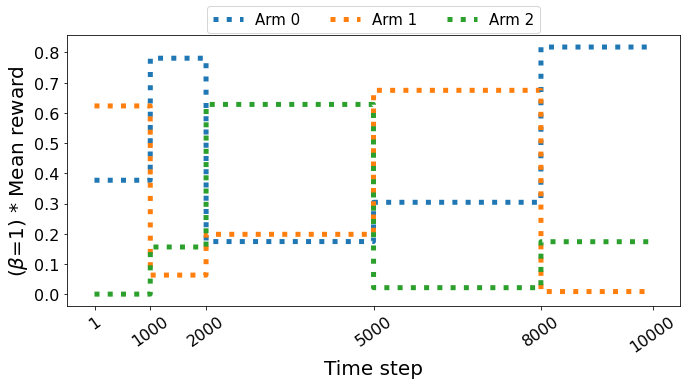

In [20]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm}", linestyle=':', linewidth=5)
#     print(f"Min expected reward for arm {arm}: {min(expected_gain)}")
    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.show()

## Validate the row exchange

Validate that no rows disappeared and now new rows appeared.

In [21]:
assert (np.sort(nonstationary_contexts, axis=0) == np.sort(new_contexts, axis=0)).all()

In [22]:
assert (np.sort(nonstationary_rewards, axis=0) == np.sort(new_rewards, axis=0)).all()

### Non-stationarity in costs

In [23]:
np.random.seed(42)

In [24]:
cost_change_points = [3000, 5000, 7000, 9000]
interval_count = len(cost_change_points) + 1

In [25]:
cost_means_range = [0.03, 0.08]

In [26]:
COSTS_RANGE_SIZE = cost_means_range[1] - cost_means_range[0]

In [27]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [
    np.random.uniform(
        cost_means_range[0], cost_means_range[1], size=(new_contexts.shape[1],)
    ) for i in range(interval_count)
]

In [28]:
interval_means

[array([0.04872701, 0.07753572, 0.0665997 , 0.05993292, 0.03780093]),
 array([0.03779973, 0.03290418, 0.07330881, 0.06005575, 0.06540363]),
 array([0.03102922, 0.07849549, 0.07162213, 0.04061696, 0.03909125]),
 array([0.03917023, 0.04521211, 0.05623782, 0.05159725, 0.04456146]),
 array([0.06059264, 0.03697469, 0.04460723, 0.04831809, 0.0528035 ])]

In [29]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [30]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

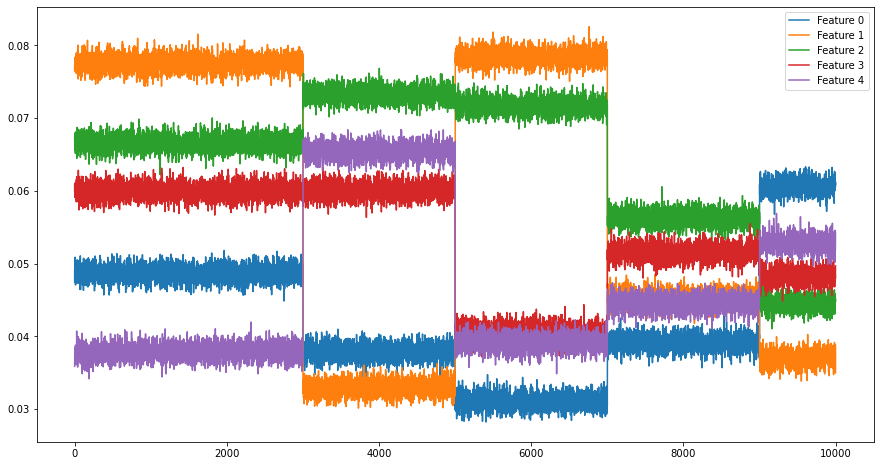

In [31]:
plot_costs(get_costs(), new_contexts.shape[0])

In [32]:
costs_obj = get_costs()

In [33]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [34]:
costs_vector.shape

(10000, 5)

## Save mean costs for plotting

In [35]:
full_cost_change_points = [0] + cost_change_points + [new_contexts.shape[0]]
cost_stationarity_regions = []
for a, b in zip(full_cost_change_points, full_cost_change_points[1:]):
    cost_stationarity_regions.append(slice(a,b))

In [36]:
mean_costs = np.zeros(costs_vector.shape)
for i, region in enumerate(cost_stationarity_regions):
    for feature in range(new_contexts.shape[1]):
        
        # For plotting
        mean_costs[region, feature] = (
            np.ones(costs_vector[region, feature].shape) * interval_means[i][feature]
        )

## Plot expected reward minus sum of costs

In [37]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

Min expected gain for arm 1: -0.12394781794797932
Min expected gain for arm 2: -0.24069385026660228
Min expected gain for arm 3: -0.29821225004764745


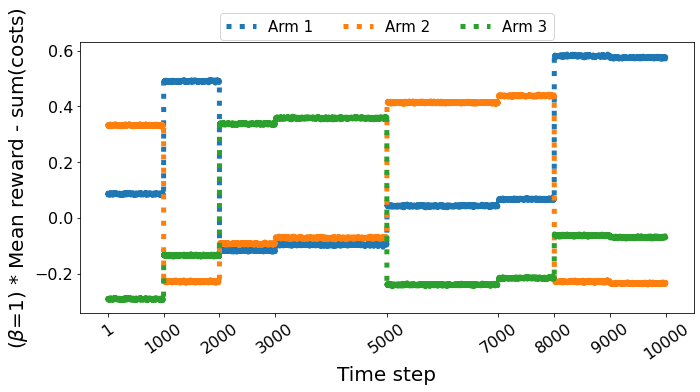

In [38]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = all_change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


In [39]:
all_change_points = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

## Testing on non-stationary data

In [40]:
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 5

In [41]:
w_lengths = [100, 300, 500, 700, 900, 1100, 1300, 1500]
gains_for_w = {}

for w_length in w_lengths:
    np.random.seed(42)
    print(f'\tEvaluation for w = {w_length}')
    gains_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
    rewards_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
    costs_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

    for i in range(NUM_REPETITIONS):
        s = time.time()
        p_alg1 = algorithms.Algorithm1(
            all_contexts=new_contexts, 
            number_of_actions=new_rewards.shape[1],
            max_no_red_context=new_contexts.shape[1],
            beta=BETA,
            delta=0.04,
            window_length=w_length,
            costs_range=COSTS_RANGE_SIZE,
        )
        print(f"Took {time.time() - s} seconds")

        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            s = time.time()
            gain_alg1, reward_alg1, cost_alg1, _ = evaluation.evaluate_on_synthetic_data(
                p_alg1,
                new_contexts[:NUM_OF_TRIALS],
                new_rewards[:NUM_OF_TRIALS],
                costs_vector[:NUM_OF_TRIALS],
                beta=BETA,
                stop_after=NUM_OF_TRIALS,
                return_full=True,
            )
            print(f"Took {time.time() - s} seconds")
            gains_alg1[i, :] = gain_alg1
            rewards_alg1[i, :] = reward_alg1
            costs_alg1[i, :] = cost_alg1

    gain_alg1 = np.mean(gains_alg1, axis=0)
    reward_alg1 = np.mean(rewards_alg1, axis=0)
    cost_alg1 = np.mean(costs_alg1, axis=0)
    print(f"Average gain: {gain_alg1[-1]}")
    gains_for_w[w_length] = gain_alg1

	Evaluation for w = 100
Took 0.0017788410186767578 seconds
Round 0, time 2022-06-15 23:45:37.050107
Round 500, time 2022-06-15 23:46:37.426787
Round 1000, time 2022-06-15 23:47:39.949979
Round 1500, time 2022-06-15 23:48:42.343681
Round 2000, time 2022-06-15 23:49:44.515764
Round 2500, time 2022-06-15 23:50:46.854237
Round 3000, time 2022-06-15 23:51:48.883424
Round 3500, time 2022-06-15 23:52:50.963564
Round 4000, time 2022-06-15 23:53:53.184502
Round 4500, time 2022-06-15 23:54:55.386026
Round 5000, time 2022-06-15 23:55:57.365450
Round 5500, time 2022-06-15 23:56:59.612630
Round 6000, time 2022-06-15 23:58:01.792338
Round 6500, time 2022-06-15 23:59:04.174973
Round 7000, time 2022-06-16 00:00:06.373978
Round 7500, time 2022-06-16 00:01:08.612062
Round 8000, time 2022-06-16 00:02:11.057692
Round 8500, time 2022-06-16 00:03:13.315382
Round 9000, time 2022-06-16 00:04:15.522555
Round 9500, time 2022-06-16 00:05:17.958916
Algorithm1 (beta=1, delta=0.04, w=100)
Beta = 1
Total gain: 7656.

Round 5000, time 2022-06-16 02:26:00.003098
Round 5500, time 2022-06-16 02:27:08.577711
Round 6000, time 2022-06-16 02:28:17.190493
Round 6500, time 2022-06-16 02:29:25.839590
Round 7000, time 2022-06-16 02:30:34.553996
Round 7500, time 2022-06-16 02:31:43.109446
Round 8000, time 2022-06-16 02:32:51.762088
Round 8500, time 2022-06-16 02:34:00.247319
Round 9000, time 2022-06-16 02:35:08.999348
Round 9500, time 2022-06-16 02:36:17.726789
Algorithm1 (beta=1, delta=0.04, w=300)
Beta = 1
Total gain: 4942.929168175211
	Total reward: 6898.0
	Total cost: 1955.0708318248064
Execution time: 22.8m
Took 1366.2914071083069 seconds
Took 0.0045318603515625 seconds
Round 0, time 2022-06-16 02:37:26.095838
Round 500, time 2022-06-16 02:38:29.158172
Round 1000, time 2022-06-16 02:39:37.488540
Round 1500, time 2022-06-16 02:40:45.874717
Round 2000, time 2022-06-16 02:41:54.284659
Round 2500, time 2022-06-16 02:43:02.823902
Round 3000, time 2022-06-16 02:44:11.260895
Round 3500, time 2022-06-16 02:45:19.5

Round 500, time 2022-06-16 05:27:35.007187
Round 1000, time 2022-06-16 05:28:58.328063
Round 1500, time 2022-06-16 05:30:21.690962
Round 2000, time 2022-06-16 05:31:44.954690
Round 2500, time 2022-06-16 05:33:08.240151
Round 3000, time 2022-06-16 05:34:31.505207
Round 3500, time 2022-06-16 05:35:54.804942
Round 4000, time 2022-06-16 05:37:18.000168
Round 4500, time 2022-06-16 05:38:41.304767
Round 5000, time 2022-06-16 05:40:04.572487
Round 5500, time 2022-06-16 05:41:28.031879
Round 6000, time 2022-06-16 05:42:51.556069
Round 6500, time 2022-06-16 05:44:15.265870
Round 7000, time 2022-06-16 05:45:38.322512
Round 7500, time 2022-06-16 05:47:01.452672
Round 8000, time 2022-06-16 05:48:24.717648
Round 8500, time 2022-06-16 05:49:47.815537
Round 9000, time 2022-06-16 05:51:11.207866
Round 9500, time 2022-06-16 05:52:34.501699
Algorithm1 (beta=1, delta=0.04, w=700)
Beta = 1
Total gain: 6479.045304934201
	Total reward: 7369.0
	Total cost: 889.9546950657976
Execution time: 27.5m
Took 1649.28

Round 6000, time 2022-06-16 09:00:45.957424
Round 6500, time 2022-06-16 09:02:15.981923
Round 7000, time 2022-06-16 09:03:46.058082
Round 7500, time 2022-06-16 09:05:16.156257
Round 8000, time 2022-06-16 09:06:46.115161
Round 8500, time 2022-06-16 09:08:16.357998
Round 9000, time 2022-06-16 09:09:46.211888
Round 9500, time 2022-06-16 09:11:16.340726
Algorithm1 (beta=1, delta=0.04, w=900)
Beta = 1
Total gain: 5230.650187464515
	Total reward: 7229.0
	Total cost: 1998.3498125354856
Execution time: 29.6m
Took 1773.8354041576385 seconds
Took 0.008550167083740234 seconds
Round 0, time 2022-06-16 09:12:46.428103
Round 500, time 2022-06-16 09:13:53.027589
Round 1000, time 2022-06-16 09:15:19.718909
Round 1500, time 2022-06-16 09:16:49.596979
Round 2000, time 2022-06-16 09:18:19.657885
Round 2500, time 2022-06-16 09:19:49.463980
Round 3000, time 2022-06-16 09:21:19.324878
Round 3500, time 2022-06-16 09:22:49.051733
Round 4000, time 2022-06-16 09:24:18.993382
Round 4500, time 2022-06-16 09:25:49

Round 500, time 2022-06-16 12:51:29.963430
Round 1000, time 2022-06-16 12:53:01.841577
Round 1500, time 2022-06-16 12:54:44.999180
Round 2000, time 2022-06-16 12:56:32.787815
Round 2500, time 2022-06-16 12:58:22.679181
Round 3000, time 2022-06-16 13:00:07.168301
Round 3500, time 2022-06-16 13:01:52.324729
Round 4000, time 2022-06-16 13:03:38.750860
Round 4500, time 2022-06-16 13:05:22.770742
Round 5000, time 2022-06-16 13:07:07.207849
Round 5500, time 2022-06-16 13:08:52.427229
Round 6000, time 2022-06-16 13:10:40.111157
Round 6500, time 2022-06-16 13:12:30.923085
Round 7000, time 2022-06-16 13:14:18.007141
Round 7500, time 2022-06-16 13:16:02.293336
Round 8000, time 2022-06-16 13:17:49.197453
Round 8500, time 2022-06-16 13:19:34.330413
Round 9000, time 2022-06-16 13:21:17.503894
Round 9500, time 2022-06-16 13:23:03.007865
Algorithm1 (beta=1, delta=0.04, w=1300)
Beta = 1
Total gain: 6517.3279507660845
	Total reward: 7460.0
	Total cost: 942.6720492339108
Execution time: 34.4m
Took 2062.

Round 6000, time 2022-06-16 17:11:12.019864
Round 6500, time 2022-06-16 17:13:01.812250
Round 7000, time 2022-06-16 17:14:50.908501
Round 7500, time 2022-06-16 17:16:40.329924
Round 8000, time 2022-06-16 17:18:29.329145
Round 8500, time 2022-06-16 17:20:18.744931
Round 9000, time 2022-06-16 17:22:07.728851
Round 9500, time 2022-06-16 17:23:56.931573
Algorithm1 (beta=1, delta=0.04, w=1500)
Beta = 1
Total gain: 5520.939880788788
	Total reward: 6931.0
	Total cost: 1410.0601192112
Execution time: 35.2m
Took 2113.170674800873 seconds
Took 0.010992050170898438 seconds
Round 0, time 2022-06-16 17:25:45.920424
Round 500, time 2022-06-16 17:26:52.647206
Round 1000, time 2022-06-16 17:28:20.756385
Round 1500, time 2022-06-16 17:30:05.948304
Round 2000, time 2022-06-16 17:31:54.713623
Round 2500, time 2022-06-16 17:33:43.943228
Round 3000, time 2022-06-16 17:35:33.325515
Round 3500, time 2022-06-16 17:37:22.819559
Round 4000, time 2022-06-16 17:39:12.400459
Round 4500, time 2022-06-16 17:41:01.47

### Oracle

In [42]:
all_stationarity_regions = [(l, r) for l,r in zip(all_change_points, all_change_points[1:])]
N_STATIONARY_PERIODS = len(all_stationarity_regions)

cost_means = np.zeros((N_STATIONARY_PERIODS, costs_vector.shape[1]))
for reg_num, region in enumerate(all_stationarity_regions):
    region_costs = costs_vector[slice(*region)]
    cost_means[reg_num, :] = region_costs.mean(axis=0)

In [43]:
gains_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):

    s = time.time()
    p_oracle = algorithms.Algorithm1_Oracle(
        all_contexts=new_contexts, 
        all_rewards=new_rewards,
        cost_means=cost_means,
        stationarity_periods=all_stationarity_regions,
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_oracle, reward_oracle, cost_oracle, _ = evaluation.evaluate_on_synthetic_data(
            p_oracle,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
        gains_oracle[i, :] = gain_oracle
        rewards_oracle[i, :] = reward_oracle
        costs_oracle[i, :] = cost_oracle


gain_oracle = np.mean(gains_oracle, axis=0)
reward_oracle = np.mean(rewards_oracle, axis=0)
cost_oracle = np.mean(costs_oracle, axis=0)
print(f"Average gain: {gain_oracle[-1]}")

Took 0.5805239677429199 seconds
Trial 0, time 2022-06-16 18:37:29.924073
Trial 500, time 2022-06-16 18:37:29.929695
Trial 1000, time 2022-06-16 18:37:29.934948
Trial 1500, time 2022-06-16 18:37:29.940173
Trial 2000, time 2022-06-16 18:37:29.945302
Trial 2500, time 2022-06-16 18:37:29.950588
Trial 3000, time 2022-06-16 18:37:29.955834
Trial 3500, time 2022-06-16 18:37:29.961419
Trial 4000, time 2022-06-16 18:37:29.967099
Trial 4500, time 2022-06-16 18:37:29.972661
Trial 5000, time 2022-06-16 18:37:29.978157
Trial 5500, time 2022-06-16 18:37:29.983614
Trial 6000, time 2022-06-16 18:37:29.989123
Trial 6500, time 2022-06-16 18:37:29.994627
Trial 7000, time 2022-06-16 18:37:30.000173
Trial 7500, time 2022-06-16 18:37:30.005696
Trial 8000, time 2022-06-16 18:37:30.011226
Trial 8500, time 2022-06-16 18:37:30.016798
Trial 9000, time 2022-06-16 18:37:30.022369
Trial 9500, time 2022-06-16 18:37:30.028069
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 8780.69062052404
	Total reward: 9245.0
	Tota

## Save the data

In [44]:
regrets = {k: gain_oracle-v for k,v in gains_for_w.items()}

In [45]:
regrets

{100: array([5.64150103e-01, 1.36415010e+00, 2.18694183e+00, ...,
        2.26867431e+03, 2.26877084e+03, 2.26886835e+03]),
 300: array([5.64150103e-01, 1.16415010e+00, 2.18694183e+00, ...,
        1.58068458e+03, 1.58076191e+03, 1.58083955e+03]),
 500: array([9.64150103e-01, 1.76415010e+00, 2.58694183e+00, ...,
        1.93980552e+03, 1.93989629e+03, 1.93998845e+03]),
 700: array([7.64150103e-01, 1.56415010e+00, 2.38694183e+00, ...,
        2.64152058e+03, 2.64161711e+03, 2.64171461e+03]),
 900: array([7.64150103e-01, 1.36415010e+00, 2.18694183e+00, ...,
        4.30927467e+03, 4.30959436e+03, 4.30991583e+03]),
 1100: array([7.64150103e-01, 1.56415010e+00, 2.58694183e+00, ...,
        3.94432410e+03, 3.94442579e+03, 3.94452972e+03]),
 1300: array([5.64150103e-01, 9.64150103e-01, 1.58694183e+00, ...,
        4.37198256e+03, 4.37247795e+03, 4.37277513e+03]),
 1500: array([7.64150103e-01, 1.56415010e+00, 1.98694183e+00, ...,
        4.14260798e+03, 4.14292680e+03, 4.14324793e+03])}

In [46]:
with open('experiments/nursery/results/regrets_for_w.pickle', 'wb') as f:
    pickle.dump(regrets , f)

In [47]:
with open('experiments/nursery/results/regrets_for_w.pickle', 'rb') as f:
    regrets = pickle.load(f)

In [48]:
all_change_point_values

[1, 1000, 2000, 3000, 5000, 7000, 8000, 9000, 10000]

In [52]:
def plot_regrets(regret_dict, reward_change_points=(), cost_change_points=(), all_change_point_values=(),):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
        
    
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'blue'),
        1: ('>', 'g'),
        2: ('d','m'),
        3: ('<','goldenrod'),
        4: ('s','r'),
        5: ('o','dodgerblue'),
        6: ('^', 'k'),
    }
    
    sorted_regret_dict = {
        k:v for k,v in sorted(regret_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    
    # Find out largest value. Do this first so change points appear first in the legend.
    max_vline=0
    for regret in sorted_regret_dict.values():
        max_vline=max(max_vline, max(regret))
        
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, linestyle=':', alpha=0.4
    )
        
    for ind, (label, regret) in enumerate(sorted_regret_dict.items()):
        
        
        label_new = f"w={label}"
        
        mark, color = ind_to_params[ind % 7]
        line, = ax.plot(regret, label=label_new, linestyle=':', 
                marker=mark, markevery=750, markersize=11, markeredgewidth=1.5,
                fillstyle='none', color=color,
                linewidth=3,
               )
        
        
    extraticks = all_change_point_values
    plt.xticks(extraticks, rotation=35, fontsize=25)
    plt.yticks(fontsize=25)
    
    ax.set_xlabel("Time Step", fontsize=38)
    ax.set_ylabel('Regret', fontsize=38)
    
    plt.legend(prop={'size': 22.5}, ncol=1);
    
    plt.savefig('nursery_window_regret.pdf', bbox_inches='tight')
    
    plt.show();

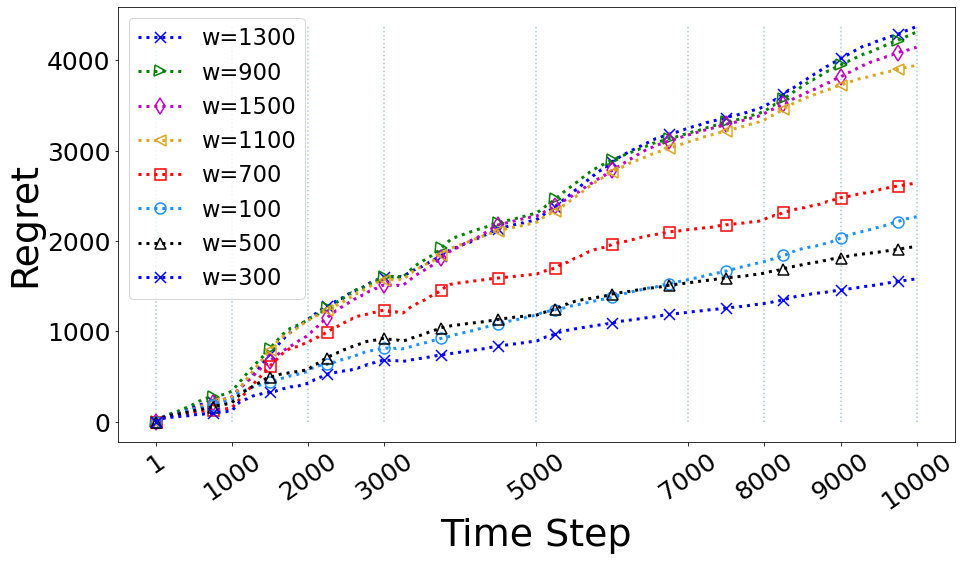

In [53]:
plot_regrets(
    regrets,
    reward_change_points=all_change_points,
    cost_change_points=cost_change_points,
    all_change_point_values=all_change_points,
)
